# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = 'train.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']
print('Data loaded successfully')

Data loaded successfully


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# What is the shape of a traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset?
n_classes = max(train['labels']) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

[13]


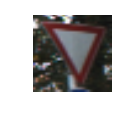

In [4]:
### Data exploration visualization

import random
import numpy as np
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

index = np.random.randint(0, len(X_train), size=(1, 10, 1))
image = X_train[index[0][0]].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image)
plt.axis('off')
print(y_train[index[0][0]])

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

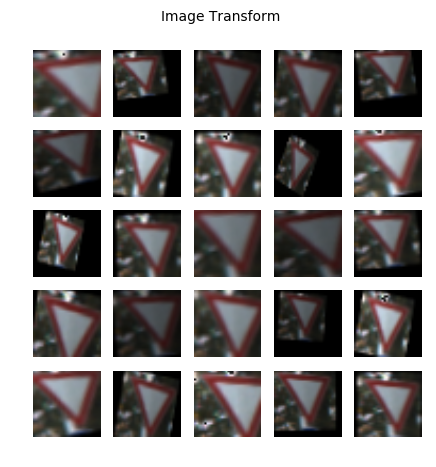

In [5]:
### Preprocess the data here.

# Code taken from
# https://github.com/vxy10/ImageAugmentation/blob/master/README.md

import cv2

def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    random_bright = 0.5 + np.random.uniform()
    image1[:,:,2] = image1[:,:,2] * random_bright
    image1 = cv2.cvtColor(image1, cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img, ang_range, shear_range, trans_range, brightness=0):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation
    ang_rot = np.random.uniform(ang_range) - ang_range/2
    rows, cols, ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((rows/2, cols/2), ang_rot, 1)

    # Translation
    tr_x = trans_range*np.random.uniform() - trans_range/2
    tr_y = trans_range*np.random.uniform() - trans_range/2
    Trans_M = np.float32([[1, 0, tr_x],[0, 1, tr_y]])

    # Shear
    pts1 = np.float32([[5, 5], [20, 5], [5, 20]])
    pt1 = 5 + shear_range*np.random.uniform() - shear_range/2
    pt2 = 20 + shear_range*np.random.uniform() - shear_range/2
    pts2 = np.float32([[pt1, 5],[pt2, pt1],[5, pt2]])
    shear_M = cv2.getAffineTransform(pts1, pts2)

    img = cv2.warpAffine(img, Rot_M, (cols, rows))
    img = cv2.warpAffine(img, Trans_M, (cols, rows))
    img = cv2.warpAffine(img, shear_M, (cols, rows))

    # Brigthness
    if brightness == 1:
        img = augment_brightness_camera_images(img)

    return img

# Test image transform function
def test_transform():
    fig = plt.figure(figsize=(5, 5))
    fig.suptitle('Image Transform')
    for i in range(25):
        plt.subplot(5,5,i+1)
        img = transform_image(image, 10, 10, 5, brightness=1)
        plt.axis('off')
        plt.imshow(img)

test_transform()

In [6]:
# Total number of images per class
def make_hist(y_data):
    hist = np.zeros((n_classes, 1))
    for i in range(len(y_data)):
        hist[y_data[i], 0] += 1
    return hist

# Display number of images per class
def display_histogram(hist, title):
    plt.bar(np.arange(n_classes), hist, align='center')
    plt.xlim([-1, n_classes])
    plt.title(title)
    plt.show()

In [7]:
# This function matches the number of images in each class
def increase_images(x_data, y_data, n_class, n_imgs):
    """
    x_data: The dataset which requires additional images
    y_data: The dataset which has the image and label
    n_class: The number of classes in the dataset
    n_imgs: The number of images per class
    """

    n, row, col, c = x_data.shape
    max_imgs = int(max(n_imgs))
    total_imgs = int(sum(max_imgs - n_imgs))
        
    X_extra = np.zeros((total_imgs, row, col, c), dtype = x_data.dtype)
    y_extra = np.zeros(total_imgs, dtype = y_data.dtype)
    start = 0
    
    for i in range(n_class):
        if n_imgs[i, 0] < max_imgs:
            reqd_imgs = max_imgs - int(n_imgs[i, 0])
            end = start + reqd_imgs
            # indices is a vector of the indices of the images in the current class i
            indices = np.argwhere(y_data == i)
            new_imgs = np.zeros((reqd_imgs, row, col, c))
            for j in range(reqd_imgs):
                idx = np.random.choice(indices[0])
                new_img = transform_image(x_data[idx], 20, 10, 5, brightness=1)
                new_imgs[j,:,:,:] = new_img

            X_extra[start:end,:,:,:] = new_imgs[0:reqd_imgs,:,:,:]
            y_extra[start:end,] = i
            start = end
    return X_extra, y_extra

In [8]:
def join_datasets(x_data1, y_data1, x_data2, y_data2):
    """
    x_data1: Original image dataset
    y_data1: Original label dataset
    x_data2: Additional image dataset
    y_data2: Additional label dataset
    """
    
    x_data12 = np.concatenate((x_data1, x_data2), axis = 0)
    y_data12 = np.concatenate((y_data1, y_data2), axis = 0)
    
    return x_data12, y_data12

In [9]:
import matplotlib.image as mpimg
from skimage import data, exposure, img_as_float
"""
- Grayscale image
- Normalize image: img_as_float - Convert an image to floating point format,
                                  with values in [0, 1].
- Process images using Gamma Correction, Histogram Equalization or Contrast Stretching
"""
def process_data(x):
    Z = np.zeros((len(x), image_shape[0], image_shape[1], 1))
    for i in range(len(x)):
        Z[i,:,:,0] = img_as_float(cv2.cvtColor(x[i], cv2.COLOR_RGB2GRAY))
        #Z[i,:,:,0] = exposure.adjust_gamma(Z[i,:,:,0], gamma=0.3)
        #Z[i,:,:,0] = exposure.equalize_hist(Z[i,:,:,0])
        p2, p98 = np.percentile(Z[i,:,:,0], (2, 98))
        Z[i,:,:,0] = exposure.rescale_intensity(Z[i,:,:,0], in_range=(p2, p98))
    return Z

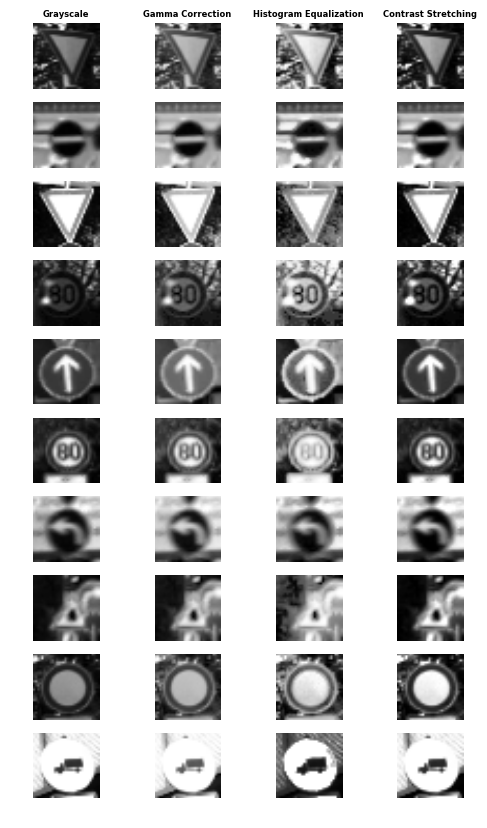

In [10]:
fig = plt.figure(figsize=(6, 10))

for i in range(10):
    img = img_as_float(cv2.cvtColor(X_train[index[0][i][0]], cv2.COLOR_RGB2GRAY))
    
    ax = fig.add_subplot(10,4,4*i+1)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_title('Grayscale', fontsize=6, fontweight='bold')

    ax = fig.add_subplot(10,4,4*i+2)
    img2 = exposure.adjust_gamma(img, gamma=0.3)
    plt.imshow(img2, cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_title('Gamma Correction', fontsize=6, fontweight='bold')

    ax = fig.add_subplot(10,4,4*i+3)
    img3 = exposure.equalize_hist(img)
    plt.imshow(img3, cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_title('Histogram Equalization', fontsize=6, fontweight='bold')

    ax = fig.add_subplot(10,4,4*i+4)
    p2, p98 = np.percentile(img, (2, 98))
    img4 = exposure.rescale_intensity(img, in_range=(p2, p98))
    plt.imshow(img4, cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_title('Contrast Stretching', fontsize=6, fontweight='bold')

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

Before processing the data, the validation set is extracted from the training set.

The unprocessed training data achieved a very high result in the original Lenet model; about 0.96% validation accuracy. This 'seems' good but if tested on difficult images to identify, would not do well.

I implemented grayscale conversion with normalization centered around 0.5. This didn't improve the validation accuracy during training, but would definitely improve the likelihood of the classifier correctly classifying a difficult image.

I decided to implement further image enhancements to improve the correct classification probability of images with low contrast or are very dark. I tested the following image processing methods:

- Gamma Correction 
- Histogram Equalization
- Contrast Stretching

Gamma Correction gave an improved result over the grayscaled image, but not nearly as good as Histogram Equalization. Histogram Equalization enhances an image with low contrast, which "spreads out the most frequent intensity values" in an image. The equalized image has a roughly linear cumulative distribution function. The downside is that images can sometimes appear unnatural [[Reference](http://scikit-image.org/docs/dev/auto_examples/plot_equalize.html)].

The alternative to Histogram Equalization is Contrast Stretching (aka Normalization). Here the image is rescaled to include all intensities that fall within 2% and 98%, using only linear scaling. Contrast Stretching is a much less harsh enhancement on the imput image.

Contrast Stretching proved to be the best method of processing the dataset, as feature distortion of the Histrogram Equalized images was too harsh.

In [11]:
### Generate data (additional data OPTIONAL!)
### and split the data into training/validation/testing sets here.

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

print('Original training set size {}'.format(len(X_train)))
X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train, test_size=0.2, random_state=0)
print('X_train post {}'.format(len(X_train)))
print('X_validation {}'.format(len(X_validation)))
print('y_train post {}'.format(len(y_train)))
print('y_validation {}'.format(len(y_validation)))

# Shuffle the training dataset
X_train, y_train = shuffle(X_train, y_train)

Original training set size 39209
X_train post 31367
X_validation 7842
y_train post 31367
y_validation 7842


Length of old_dataset   31367
Length of extra_dataset 45990
Length of new_dataset   77357


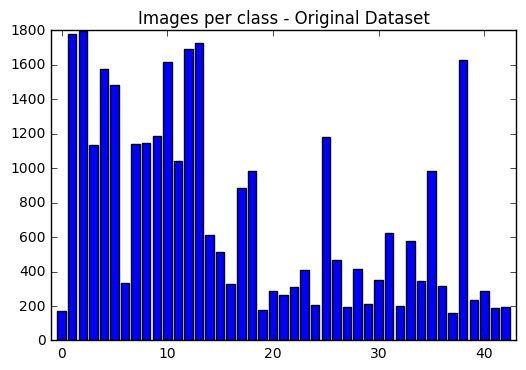

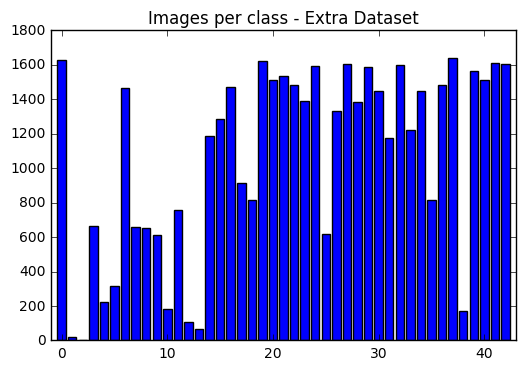

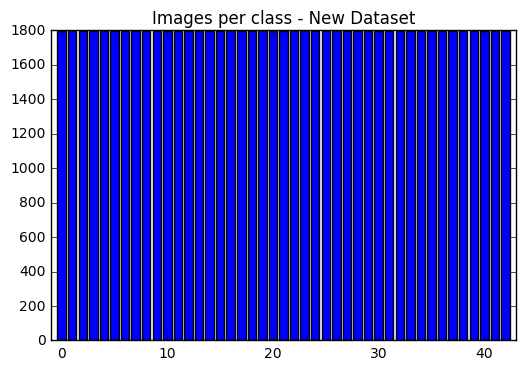

In [12]:
# This cell is used to increase the number of images per class
# so that each class has the same number of images

# Calculate number of images per class
hist = make_hist(y_train)

# Create the extra dataset
X_train_extra, y_train_extra = increase_images(X_train,
                                               y_train,
                                               n_classes,
                                               hist)
# Join extra dataset with old dataset
X_train_new, y_train_new = join_datasets(X_train,
                                         y_train,
                                         X_train_extra,
                                         y_train_extra)

print('Length of old_dataset   {}'.format(len(X_train)))
print('Length of extra_dataset {}'.format(len(X_train_extra)))
print('Length of new_dataset   {}'.format(len(X_train_new)))

# Display old dataset, extra dataset and new dataset
old_dataset = make_hist(y_train)
extra_dataset = make_hist(y_train_extra)
new_dataset = make_hist(y_train_new)
display_histogram(old_dataset, 'Images per class - Original Dataset')
display_histogram(extra_dataset, 'Images per class - Extra Dataset')
display_histogram(new_dataset, 'Images per class - New Dataset')

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

The training and testing datasets are given. The validation set was extracted from the training set (ratio 1:5) prior to generating additional data.

Training will favour a category with more images than one with fewer. This is due to the improved weight updates via backpropagation for each input image. I investigated the number of images per category. They range from about 180 to 1800. Due to these highly unscaled numbers, I decided to embark on the journey of matching the number of images per class. I used [this code](https://github.com/vxy10/ImageAugmentation/blob/master/README.md) to transform existing images. I then generated transformed images so that each class would have the same number of images as the class with the maximum. I added these new images to the original dataset and trained the model.

In [12]:
### Define your architecture here.

In [13]:
def conv2d(x, W, b, strides=1):
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)

def maxpool2d(x, k=2):
    return tf.nn.max_pool(x,
                          ksize=[1, k, k, 1],
                          strides=[1, k, k, 1],
                          padding='VALID')

def fully_con(x, W, b):
    x = tf.add(tf.matmul(x, W), b)
    return tf.nn.relu(x)

def dropout(x, keep_prob):
    return tf.nn.dropout(x, keep_prob)

In [14]:
from tensorflow.contrib.layers import flatten

def convnet(x):    
    # Network Parameters
    mu = 0
    sigma = 0.1
    
    # Store layers weight & bias
    weights = {
        'wc1': tf.Variable(tf.truncated_normal(shape=(3, 3, 1, 32), mean = mu, stddev = sigma)),
        'wc2': tf.Variable(tf.truncated_normal(shape=(3, 3, 32, 50), mean = mu, stddev = sigma)),
        'wc3': tf.Variable(tf.truncated_normal(shape=(5, 5, 50, 76), mean = mu, stddev = sigma)),
        'wc4': tf.Variable(tf.truncated_normal(shape=(7, 7, 76, 100), mean = mu, stddev = sigma)),
        'wd1': tf.Variable(tf.truncated_normal(shape=(400, 200), mean = mu, stddev = sigma)),
        'wd2': tf.Variable(tf.truncated_normal(shape=(200, 100), mean = mu, stddev = sigma)),
        'out': tf.Variable(tf.truncated_normal(shape=(100, 43), mean = mu, stddev = sigma))}

    biases = {
        'bc1': tf.Variable(tf.zeros(32)),
        'bc2': tf.Variable(tf.zeros(50)),
        'bc3': tf.Variable(tf.zeros(76)),
        'bc4': tf.Variable(tf.zeros(100)),
        'bd1': tf.Variable(tf.zeros(200)),
        'bd2': tf.Variable(tf.zeros(100)),
        'out': tf.Variable(tf.zeros(43))}
    
    # Layer 1:
    # Convolutional. Input = 32x32x1. Output = 30x30x32.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'], strides=1)

    # Layer 2:
    # Convolutional. Input = 30x30x32. Output = 28x28x50.
    # Pooling.       Input = 28x28x50. Output = 14x14x50.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'], strides=1)
    conv2 = maxpool2d(conv2, k=2)
    
    # Layer 3:
    # Convolutional. Input = 14x14x50. Output = 10x10x76.
    conv3 = conv2d(conv2, weights['wc3'], biases['bc3'], strides=1)

    # Layer 4:
    # Convolutional. Input = 10x10x76. Output = 4x4x100.
    # Pooling.       Input = 4x4x100.   Output = 2x2x100.
    conv4 = conv2d(conv3, weights['wc4'], biases['bc4'], strides=1)
    conv4 = maxpool2d(conv4, k=2)
    
    # Flatten. Input = 2x2x100. Output = 400.
    fc0 = flatten(conv4)

    # Layer 5:
    # Fully Connected. Input = 400. Output = 200.
    # Dropout.
    fc1 = fully_con(fc0, weights['wd1'], biases['bd1'])
    fc1 = dropout(fc1, keep_prob)

    # Layer 6:
    # Fully Connected. Input = 200. Output = 100.
    # Dropout.
    fc2 = fully_con(fc1, weights['wd2'], biases['bd2'])
    fc2 = dropout(fc2, keep_prob)

    # Layer 7:
    # Fully Connected. Input = 100. Output = 43.
    logits = tf.add(tf.matmul(fc2, weights['out']), biases['out'])

    return logits

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

I started with the basic [LeNet-5](http://yann.lecun.com/exdb/lenet/) architecture. The Lenet model was giving poor validation results on pre-processed images, so I increased the number of convolutional layers from 2 to 3, each having max pooling. This was still not giving great training results so I increased it again to 4 convolutional layers. Because max pooling halves the size of your image, it is unreasonable to perform four max pooling operations. I therefore only performed max pooling after the second and fourth convolutional layers. The depth of each layer was chosen randomly.

As the model became more complex, I added dropout to prevent overfitting.

After completing the model and running it on additional traffic signs obtained around Cape Town, I realised that my model could not recognize a simple speed limit 60km/h traffic sign. Having a depth of 6 and increasing up to 25 over the 4 convolutional layers was insufficient for the model to pick up enough features to classify the 60km/h sign correctly. I thus increased the depth of each layer and saw a significant improvement in results.

Larger filters sizes were chosen for the later confolutional layers to improve the detection of large features.

### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. The German Traffic Signs Dataset are RGB converted to grayscale, therefore C = 1. Input images are therefore 32x32x1.

### Architecture
**Layer 1: Convolutional.** Input 32x32x1. Output 30x30x32.

**Activation.** ReLU.

**Layer 2: Convolutional.** Input 30x30x32. Output 28x28x50.

**Activation.** ReLU.

**Max Pooling.** Output: 14x14x50.

**Layer 3: Convolutional.** Input 14x14x50. Output 10x10x76.

**Activation.** ReLU

**Layer 4: Convolutional.** Input 10x10x76. Output 4x4x100.

**Activation.** ReLU

**Max Pooling.** Input 4x4x100. Output: 2x2x100

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D.

**Layer 5: Fully Connected.** Input: 400. Output: 200.

**Activation.** ReLU

**Dropout.** Keep Probability: 0.5

**Layer 6: Fully Connected.** Input: 200. Output: 100.

**Activation.** ReLU

**Dropout.** Keep Probability: 0.5

**Layer 7: Fully Connected (Logits).** Input: 100. Output: 43.

### Output
Return the Logits.


In [15]:
### Train your model here.

In [15]:
# Hyperparameters
EPOCHS = 20
BATCH_SIZE = 128
rate = 0.001
drop = 0.5         # Dropout, probability to keep units

In [16]:
# x is a placeholder for a batch of input images
# y is a placeholder for a batch of output labels
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

# Training pipeline to train the German Traffic Sign Dataset
logits = convnet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

# Evaluate the loss and accuracy of the model
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x,
                                                           y: batch_y,
                                                           keep_prob: 1})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [17]:
# Choose which dataset to use:
# X_train   - unequal no. of images per class (original dataset)
# X_train_new - equal no. of images per class
# The same applies for y_train
X_train = X_train_new
y_train = y_train_new

# Process dataset from RGB -> grayscale -> contrast stretching
X_train_processed = process_data(X_train)
X_validation_processed = process_data(X_validation)

In [19]:
import time
start_time = time.time()

# Run the training data through the training pipeline to train the model.
# Before each epoch, shuffle the training set.
# After each epoch, measure the loss and accuracy of the validation set.
# Save the model after training.
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_processed, y_train = shuffle(X_train_processed, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_processed[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,
                                                    keep_prob: drop})
            
        validation_accuracy = evaluate(X_validation_processed, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'traffic_model')
    print("Model saved")
    
    print("--- %s seconds ---" % (time.time() - start_time))

Training...

EPOCH 1 ...
Validation Accuracy = 0.870

EPOCH 2 ...
Validation Accuracy = 0.958

EPOCH 3 ...
Validation Accuracy = 0.978

EPOCH 4 ...
Validation Accuracy = 0.983

EPOCH 5 ...
Validation Accuracy = 0.990

EPOCH 6 ...
Validation Accuracy = 0.990

EPOCH 7 ...
Validation Accuracy = 0.992

EPOCH 8 ...
Validation Accuracy = 0.991

EPOCH 9 ...
Validation Accuracy = 0.992

EPOCH 10 ...
Validation Accuracy = 0.991

EPOCH 11 ...
Validation Accuracy = 0.992

EPOCH 12 ...
Validation Accuracy = 0.992

EPOCH 13 ...
Validation Accuracy = 0.994

EPOCH 14 ...
Validation Accuracy = 0.994

EPOCH 15 ...
Validation Accuracy = 0.992

EPOCH 16 ...
Validation Accuracy = 0.994

EPOCH 17 ...
Validation Accuracy = 0.995

EPOCH 18 ...
Validation Accuracy = 0.991

EPOCH 19 ...
Validation Accuracy = 0.995

EPOCH 20 ...
Validation Accuracy = 0.995

Model saved
--- 802.0709571838379 seconds ---


In [20]:
### Test on the German Traffic Sign Test Dataset
"""
Restore model and check its performance against the test set.
Only run this once you are satisfied that your model is trained well.
This prevents leaking of test data into the model training process.
A good result against the test data indicates a generalized model.
"""
import tensorflow as tf

saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, './traffic_model')

    X_test_processed = process_data(X_test)
    test_accuracy = evaluate(X_test_processed, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.952


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

The ADAM optimizer is more sophisticated than the Gradient Descent optimizer. It uses momentum to prevent getting stuck in local optima and reduces the learning rate during training. These are good tricks to improving the optimization process. On the downside, the ADAM optimizer requires more computation power, but that is not a problem with this example.

The batch size was taken from the Lenet model example. I would have reduced this if my computer memory was struggling to handle the training.

Due to the depth of the convolutional neural network, the trained model achieves a high validation accuray after each epoch. After 20 epochs the validation accuracy doesn't improve much.

Hyperparameters were varied and tested for optimum performance. A learning rate of 0.001 provided good results. Using the ADAM optimizer also reduces the learning rate over training time. A dropout of 50% also proved good.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

Initially I built a simple model that gave me a good validation accuracy over 30 epochs, even better over 50 epochs. I then continued with the project and collected my own images and ran them through the model. This gave me very interesting results. I know it is not correct to adapt your model to test data, but in this case the softmax probabilities gave a clear indication that my model could not classify a simple 60 km/h traffic sign correctly.

I realised the depth of my convolutional layers was too small for the model to pick up enough features in the image. I increased the depth of each convolutional layer. This enabled the model to detect enough features of the sign to correctly classify it. Fewer epochs were needed aswell.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [21]:
### Load the random traffic sign images taken in Cape Town
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
# Visualizations will be shown in the notebook.
%matplotlib inline

path = './Images_Reduced/'
l = len(os.listdir(path))
CT_signs = np.zeros((l,32,32,3), dtype='uint8')
i = 0
for file in os.listdir(path):
    if file.endswith('.jpg'):
        image = cv2.imread(path + file, 1)
        image = cv2.resize(image, (32,32))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        CT_signs[i] = image
        i += 1

In [22]:
### Step 1 of project

a = len(CT_signs)
print("Number of training examples =", 0)
print("Number of testing examples =", a)
print("Image data shape =", CT_signs.shape)
print("Image data type =", CT_signs.dtype)
print("Number of classes =", 43)

Number of training examples = 0
Number of testing examples = 22
Image data shape = (22, 32, 32, 3)
Image data type = uint8
Number of classes = 43


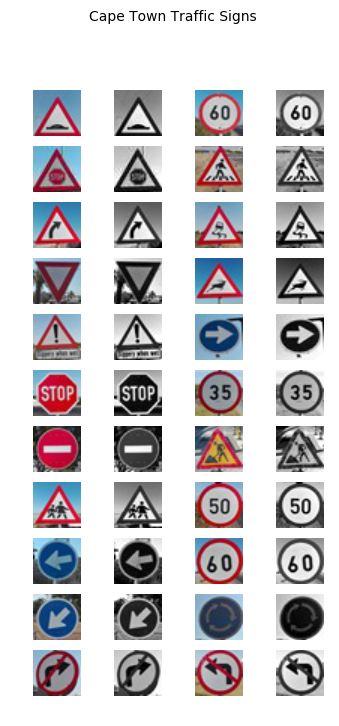

In [23]:
### Data exploration visualization

CT_signs_processed = process_data(CT_signs)

fig = plt.figure(figsize=(4, 10))
fig.suptitle('Cape Town Traffic Signs')
for i in range(a):
    plt.subplot(14, 4, 2*i+1)
    img = CT_signs[i]
    plt.axis('off')
    plt.imshow(img)
    
    plt.subplot(14, 4, 2*i+2)
    img2 = img_as_float(cv2.cvtColor(CT_signs[i], cv2.COLOR_RGB2GRAY))
    p2, p98 = np.percentile(img2, (2, 98))
    img2 = exposure.rescale_intensity(img2, in_range=(p2, p98))
    plt.axis('off')
    plt.imshow(img2, cmap='gray')

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

Of the images displayed above, 5 images are chosen that give some insight into the workings and flaws of the model. These are:

- Stop sign
- Warning, stop sign ahead
- Speed limit 35km/h
- Keep left (1)
- Keep left (2)

The images were taken during the day so bad lighting situations were not tested. The images were cropped and resized to 32x32x3. This tends to blur some of the finer details in some of the signs.

**Stop sign & Warning, stop sign ahead**

An interesting result is that of the two stop signs. The first is a classic octagonal stop sign and the second a triangle with a stop sign inside it. The first sign is categorized in the model, whereas the second isn't. The model accurately predicts the first stop sign correctly. For the second stop sign, I expected the model to predict atleast a 30% probability that it was a stop sign, as it should detect the stop sign features inside the triangle. Indeed, this was not the case. The model predicts with highest probability that it is a 'Dangerous curve to the right' sign. This can be understood as that sign is of similar shape. 

Another interesting observation is that the 'Dangerous curve to the right' sign is a mirror image (about the y-axis) to the 'Dangerous curve to the left' sign. Since the input sign 'Warning, stop sign ahead' is symmetrical, why is there almost no probability that it is a 'Dangerous curve to the left' sign? This may be as a result of the features in the convolutional layers. The stop sign results could be caused by a number of things:

- Inability of the model to detect the smaller stop sign due to size differences in the features.
- Incorrectly sized filters resulting in the correct features not being detected.
- Poor image quality, making it very difficult for the filter to detect specific features.

I tried changing the filter size, but this did not improve the result. I think a combination of these factors is making it difficult ot detect the smaller stop sign.

**Speed limit 35km/h**

The third image is the 'Speed limit 35km/h' traffic sign. There is no category for 35km/h, the closest category being 30km/h. The model correctly categorizes, with convincing probability, that this is a 30km/h sign. A '5' has some features of a '0' and so it is expected that there should be no other competing categories.

**Keep left (1)**

The fourth image is 'Keep left'. The model shows some uncertainty in it's softmax probabilities, and produces 3 categories of similar probability. Even though it's second highest probability is the correct category, the model produces the highest probability for a 'Keep right' sign.

**Keep left (2)**

The final image is also a 'Keep left' sign. The model shows confidence in it's prediction and achieves the correct result. It is possibly due to the angle of the arrow that it makes the correct prediction.

**Repeatability**

The model was trained several times and the softmax predictions produced on the Cape Town traffic signs.

The second image ('Warning, stop sign ahead') prediction changed between 'Dangerous curve to the right' and 'Slippery road'. Both sign categories are of similar shape to the input image. 

Other images also changed prediction when the model is re-trained. It seems that the model sometimes struggles to detect larger features, such as animated children, and therefore does not always categorize them correctly. This could be a result of too few convolutional layers in the architecture.

This shows moderate repeatability in the model, which in real life situations is unacceptable.

In [25]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

In [24]:
report = np.zeros((5,32,32,3), dtype='uint8')
report[0] = CT_signs[10]
report[1] = CT_signs[2]
report[2] = CT_signs[11]
report[3] = CT_signs[16]
report[4] = CT_signs[18]

In [26]:
### Test model on the Cape Town traffic signs

report_processed = process_data(report)
CT_signs_processed = process_data(CT_signs)

saver = tf.train.Saver()
softmax_operation = tf.nn.softmax(logits)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_probability = sess.run(softmax_operation, feed_dict=
                                   {x: report_processed,
                                    keep_prob: 1})
    test_prediction = np.argmax(test_probability, 1)
    # top_k predictions
    topk = sess.run(tf.nn.top_k(tf.constant(test_probability), k=3))

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

No, my model does not perform nearly as well on the Cape Town images compared to the German Traffic Sign Test Dataset. The Test Dataset produces a test accuracy of 95.2%, whereas the selected Cape Town images produce an accuracy of 64% (14/22).

If I select only the Cape Town images that have corresponding categories in the German Dataset, the accuracy is approximately 82% (14/17)

An interesting observation from the 22 images at the end of the document, is that 2 very similar input images of 60km/h signs produce completely different outputs.

In [27]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

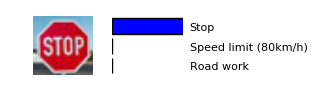

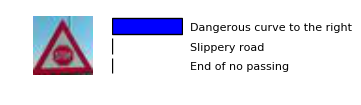

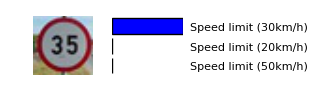

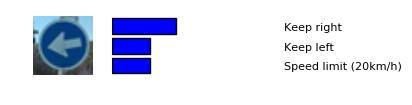

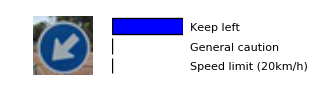

In [28]:
import csv
from pylab import *

with open('./signnames.csv', 'r') as signnames:
    reader = csv.reader(signnames)
    signnames = list(reader)
    signnames = signnames[1::]

# Display report results
for i in range(len(report)):
    fig = figure(figsize=(2, 20))
    fig.add_subplot(a, 2, 2*i+1)
    img = report[i]
    axis('off')
    imshow(img)

    fig.add_subplot(a, 2, 2*i+2)
    barh(-np.arange(3), topk[0][i], align='center')
    axis('off')
    for j in range(3):
        text_pos = [1.1, -j-0.2]
        text(text_pos[0], text_pos[1], signnames[topk[1][i][j]][1],
            fontsize=8)

    show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

This question is answered in detail in Question 6.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

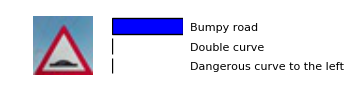

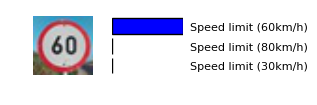

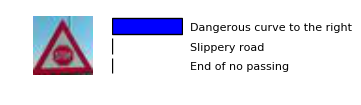

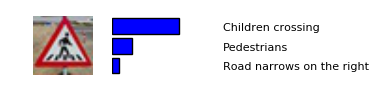

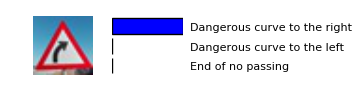

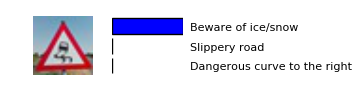

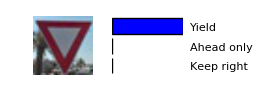

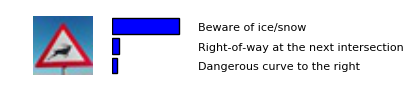

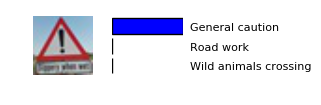

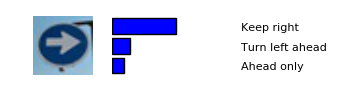

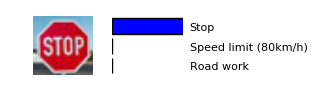

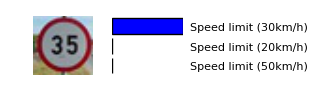

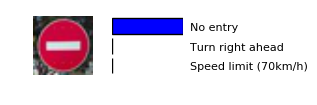

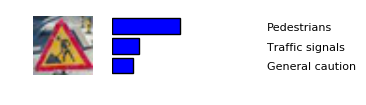

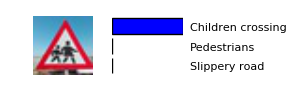

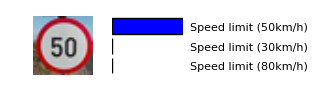

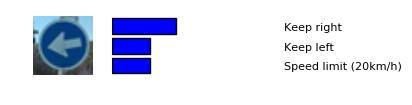

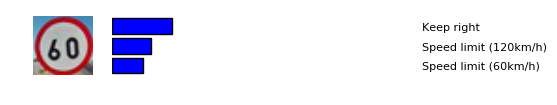

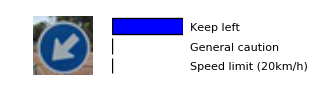

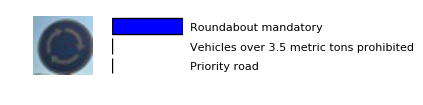

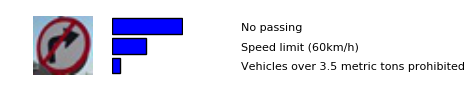

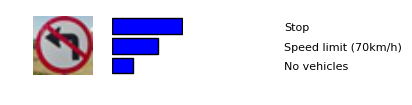

In [29]:
# Display all images collected around Cape Town

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_probability = sess.run(softmax_operation, feed_dict=
                                   {x: CT_signs_processed,
                                    keep_prob: 1})
    test_prediction = np.argmax(test_probability, 1)
    # top_k predictions
    topk = sess.run(tf.nn.top_k(tf.constant(test_probability), k=3))

for i in range(a):
    fig = figure(figsize=(2, 20))
    fig.add_subplot(a, 2, 2*i+1)
    img = CT_signs[i]
    axis('off')
    imshow(img)

    fig.add_subplot(a, 2, 2*i+2)
    barh(-np.arange(3), topk[0][i], align='center')
    axis('off')
    for j in range(3):
        text_pos = [1.1, -j-0.2]
        text(text_pos[0], text_pos[1], signnames[topk[1][i][j]][1],
            fontsize=8)

    show()